# Feature Selection

*   **Reduces Overfitting**: Less redundant data means less opportunity to make decisions based on noise.
*   **Improves Accuracy**: Less misleading data means modeling accuracy improves.
*   **Reduces Training Time**: fewer data points reduce algorithm complexity and algorithms train faster.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import ds_functions as ds
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold

data1 = pd.read_csv('Datasets/heart_failure_clinical_records_dataset.csv', sep=',', decimal='.')
data2 = pd.read_csv('Datasets/qsar_oral_toxicity.csv', sep=';', decimal='.')

## Aux Functions

In [4]:
def remove_corr_features(dataframe, bound):
    df = dataframe.copy()
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > bound)]
    df = df.drop(df[to_drop], axis=1)
    
    return df

def remove_percentile_features(X, y, percentile):
    test = SelectPercentile(score_func=chi2, percentile=percentile)
    fit = test.fit(X, y)
    features = fit.transform(X)
    
    return features, y

def remove_low_variance(X, y, t):
    selector = VarianceThreshold(threshold=t)
    X_new = selector.fit_transform(X)
    
    return X_new, y

def select_k_best(dataframe, k):
    df = dataframe.copy()
    y: np.ndarray = df.pop('DEATH_EVENT').values
    X: np.ndarray = df.values
        
    test = SelectKBest(score_func=f_classif, k=k)
    selector = test.fit(X, y)
    X_new = selector.transform(X)
    
    return X_new, y, selector.get_support(indices=True)

def best_feature_selection_data1(dataframe):
    df = dataframe.copy()
    y: np.ndarray = df.pop('DEATH_EVENT').values
    X: np.ndarray = df.values
        
    test = SelectKBest(score_func=f_classif, k=2)
    X_new = test.fit_transform(X, y)
    
    return X_new, y

def best_feature_selection_data2(dataframe):
    df = dataframe.copy()
    df = remove_corr_features(df, 0.75)
    
    y: np.ndarray = df.pop(df.columns[-1]).values
    X: np.ndarray = df.values
        
    X, y = remove_low_variance(X, y, .98 * (1 - .98))
        
    X, y = remove_percentile_features(X, y, 30)
        
    return X, y

## Heart Failure Dataset

* ### No significantly correated features

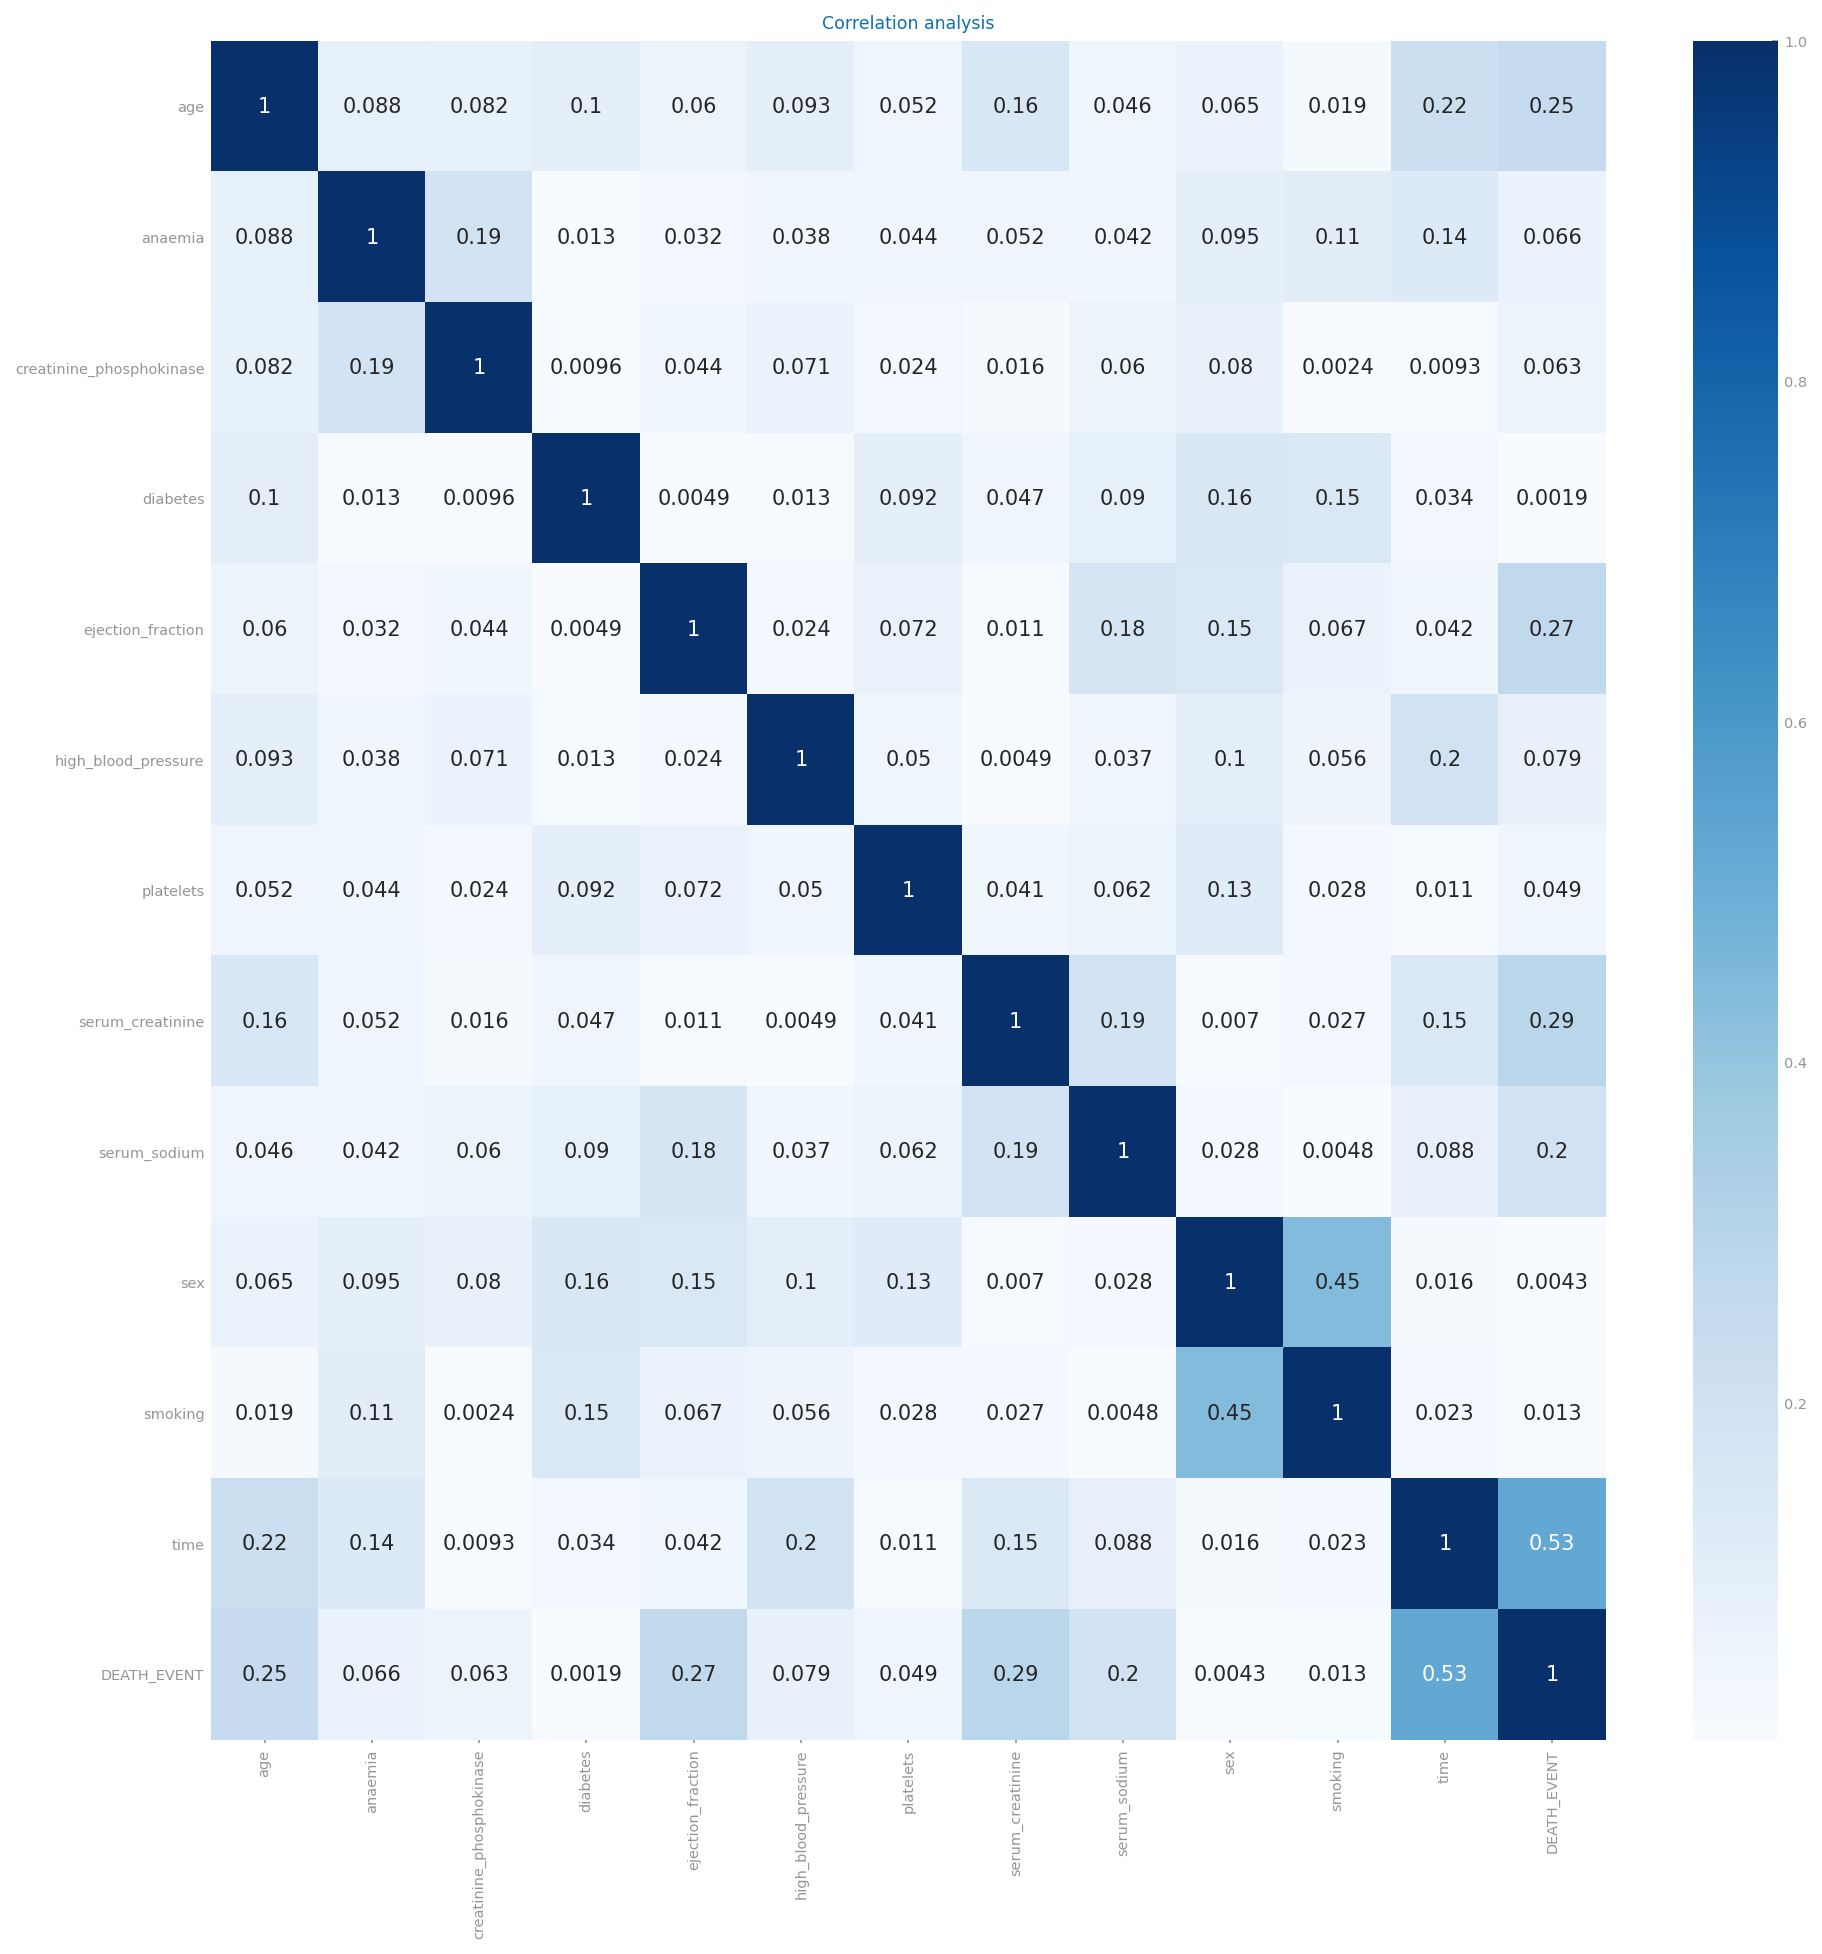

In [3]:
fig = plt.figure(figsize=[15, 15])
cor_matrix1 = data1.corr().abs()
sns.heatmap(cor_matrix1, xticklabels=cor_matrix1.columns, yticklabels=cor_matrix1.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

(299, 13)
[False False False False False False  True False False False False False]
[False False False False False False  True False False False False  True]
[False False  True False False False  True False False False False  True]
[False False  True False  True False  True False False False False  True]
[ True False  True False  True False  True False False False False  True]
[ True False  True False  True False  True  True False False False  True]
[ True False  True False  True False  True  True  True False False  True]
[ True False  True False  True  True  True  True  True False False  True]
[ True False  True False  True  True  True  True  True False False  True]
[ True  True  True False  True  True  True  True  True False False  True]
[ True  True  True False  True  True  True  True  True False  True  True]
[ True  True  True False  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True]


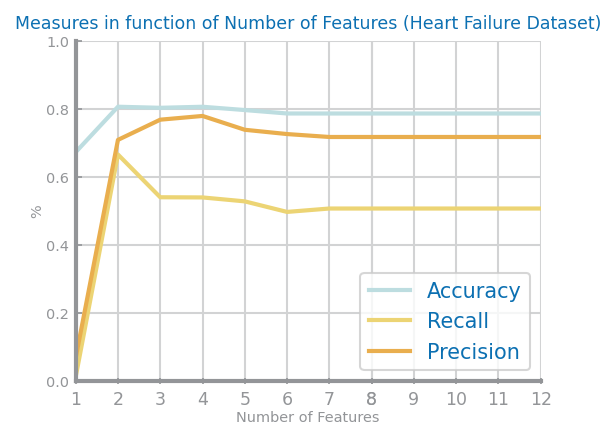

In [2]:
print(data1.shape)

data1_copy = data1.copy()

y: np.ndarray = data1_copy.pop('DEATH_EVENT').values
X: np.ndarray = data1_copy.values
    
labels = pd.unique(y)

n_features = [1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12]
acc_values = []
rec_values = []
pre_values = []

values = {}
for k in n_features:
    # Feature selection
    test = SelectKBest(score_func=chi2, k=k)
    fit = test.fit(X, y)
    features = fit.transform(X)
    print(fit.get_support())

    acc = 0
    rec = 0
    pre = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for trn_index, tst_index in skf.split(features, y):

        trnX, tstX = features[trn_index], features[tst_index]
        trnY, tstY = y[trn_index], y[tst_index]

        clf = GaussianNB()
        clf.fit(trnX, trnY)
        prdY = clf.predict(tstX)
        acc += metrics.accuracy_score(tstY, prdY)
        rec += metrics.recall_score(tstY, prdY)
        pre += metrics.precision_score(tstY, prdY)

    acc_values.append(acc/5)
    rec_values.append(rec/5)
    pre_values.append(pre/5)

values['Accuracy'] = acc_values
values['Recall'] = rec_values
values['Precision'] = pre_values

ds.multiple_line_chart(n_features, values, title='Measures in function of Number of Features (Heart Failure Dataset)',
                           xlabel='Number of Features', ylabel='%', percentage=True)

plt.show()

### Test best feature selection

In [26]:
print(data1.shape)

data1_copy = data1.copy()

y: np.ndarray = data1_copy.pop('DEATH_EVENT').values
X: np.ndarray = data1_copy.values

X_new, y_new = best_feature_selection_data1(data1)
print(X_new.shape)

(299, 13)
(299, 4)


In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Before feature selection
acc = 0
rec = 0
pre = 0
for trn_index, tst_index in skf.split(X, y):
    trnX, tstX = X[trn_index], X[tst_index]
    trnY, tstY = y[trn_index], y[tst_index]
    clf = GaussianNB()
    clf.fit(trnX, trnY)
    prdY = clf.predict(tstX)
    acc += metrics.accuracy_score(tstY, prdY)
    rec += metrics.recall_score(tstY, prdY)
    pre += metrics.precision_score(tstY, prdY)
    
print('Accuracy before: ' + str(acc/5))
print('Recall before: ' + str(rec/5))
print('Precision before: ' + str(pre/5) + '\n')


# After feature selection
acc = 0
rec = 0
pre = 0
for trn_index, tst_index in skf.split(X_new, y_new):
    trnX, tstX = X_new[trn_index], X_new[tst_index]
    trnY, tstY = y_new[trn_index], y_new[tst_index]
    clf = GaussianNB()
    clf.fit(trnX, trnY)
    prdY = clf.predict(tstX)
    acc += metrics.accuracy_score(tstY, prdY)
    rec += metrics.recall_score(tstY, prdY)
    pre += metrics.precision_score(tstY, prdY)
    
print('Accuracy after: ' + str(acc/5))
print('Recall after: ' + str(rec/5))
print('Precision after: ' + str(pre/5))

Accuracy before: 0.7859887005649717
Recall before: 0.5063157894736843
Precision before: 0.7168831168831169

Accuracy after: 0.8058757062146892
Recall after: 0.5389473684210526
Precision after: 0.7787947346770876


## Oral Toxicity Dataset

* ### Remove all correlated features (TEST)

0.95: (8991, 1010)
0.9: (8991, 987)
0.85: (8991, 972)
0.8: (8991, 957)
0.75: (8991, 932)
0.7: (8991, 909)
0.65: (8991, 879)
0.6: (8991, 847)
0.55: (8991, 803)
0.5: (8991, 763)


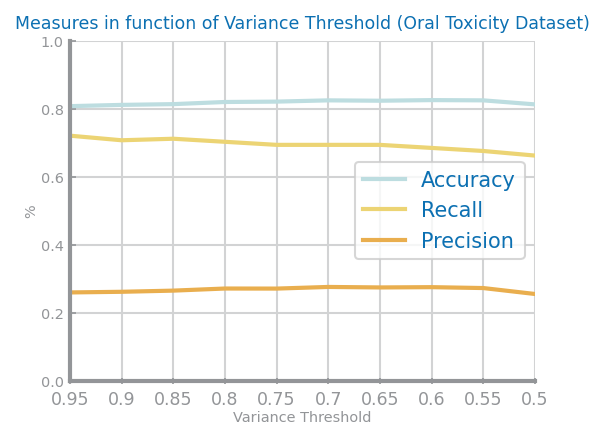

In [5]:
df = data2.copy()
# Cast target variable to binary
df[df.columns[-1]] = (df[df.columns[-1]] == 'positive').astype(int)

labels = pd.unique(y)

corr = [.95, .90, .85, .80, .75, .70, .65, .60, .55, .50]
acc_values = []
rec_values = []
pre_values = []

values = {}
for c in corr:
    # remove corr
    data2_no_corr = remove_corr_features(df, c)
    print(str(c) + ': ' + str(data2_no_corr.shape))
    
    y: np.ndarray = data2_no_corr.pop(data2_no_corr.columns[-1]).values
    X: np.ndarray = data2_no_corr.values

    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

    clf = GaussianNB()
    clf.fit(trnX, trnY)
    prdY = clf.predict(tstX)
    acc_values.append(metrics.accuracy_score(tstY, prdY))
    rec_values.append(metrics.recall_score(tstY, prdY))
    pre_values.append(metrics.precision_score(tstY, prdY))

values['Accuracy'] = acc_values
values['Recall'] = rec_values
values['Precision'] = pre_values

ds.multiple_line_chart(corr, values, title='Measures in function of Variance Threshold (Oral Toxicity Dataset)',
                         xlabel='Variance Threshold', ylabel='%', percentage=True)

plt.show()

* ### Remove Corr Features (> 0.75)

In [47]:
print(data2.shape)
data2_no_corr = remove_corr_features(data2, 0.75)
print(data2_no_corr.shape)

# Cast target variable to binary
data2_no_corr[data2_no_corr.columns[-1]] = (data2_no_corr[data2_no_corr.columns[-1]] == 'positive').astype(int)

y: np.ndarray = data2_no_corr.pop(data2_no_corr.columns[-1]).values
X: np.ndarray = data2_no_corr.values

(8991, 1025)
(8991, 932)


* ### remover as features que não variam muito (TEST)

0.24: (8991, 2)
0.21000000000000002: (8991, 8)
0.15999999999999998: (8991, 17)
0.08999999999999998: (8991, 56)
0.04750000000000004: (8991, 209)
0.019600000000000017: (8991, 609)
0: (8991, 762)


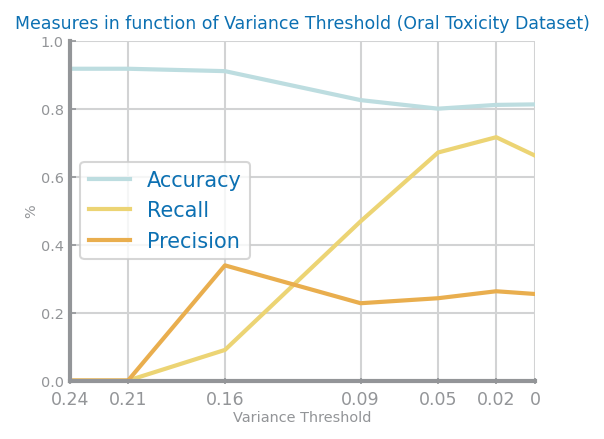

In [6]:
labels = pd.unique(y)

threshold = [.6 * (1 - .6), .7 * (1 - .7), .8 * (1 - .8), .9 * (1 - .9), .95 * (1 - .95), .98 * (1 - .98), 0]
percent = [60, 70, 80, 90, 95, 98, 100]
acc_values = []
rec_values = []
pre_values = []

values = {}
for t in threshold:
    # remove low variance
    features, y = remove_low_variance(X, y, t)
    print(str(t) + ': ' + str(features.shape))

    trnX, tstX, trnY, tstY = train_test_split(features, y, train_size=0.7, stratify=y, random_state=42)

    clf = GaussianNB()
    clf.fit(trnX, trnY)
    prdY = clf.predict(tstX)
    acc_values.append(metrics.accuracy_score(tstY, prdY))
    rec_values.append(metrics.recall_score(tstY, prdY))
    pre_values.append(metrics.precision_score(tstY, prdY))

values['Accuracy'] = acc_values
values['Recall'] = rec_values
values['Precision'] = pre_values

ds.multiple_line_chart([round(t, 2) for t in threshold], values, title='Measures in function of Variance Threshold (Oral Toxicity Dataset)',
                         xlabel='Variance Threshold', ylabel='%', percentage=True)

plt.show()

* ### Remove low variance (>98%)

In [11]:
# remove low variance
X2, y2 = remove_low_variance(X, y, .98 * (1 - .98))
print('98%: ' + str(features.shape))

98%: (8991, 609)


* ### Select percentile (TEST)

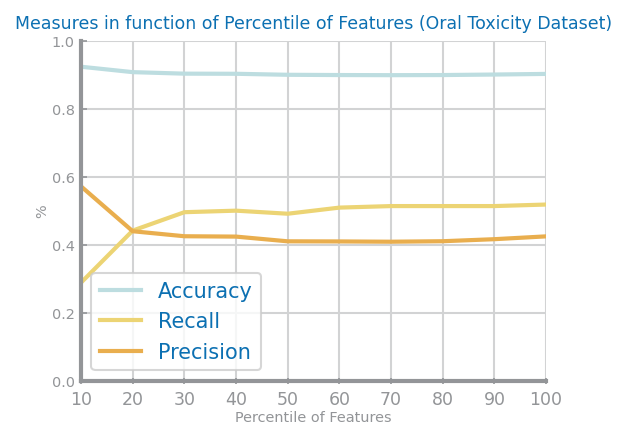

In [13]:
labels = pd.unique(y)

percentile = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
acc_values = []
rec_values = []
pre_values = []

values = {}
for n in percentile:
    # Feature selection
    test = SelectPercentile(score_func=chi2, percentile=n)
    fit = test.fit(X2, y2)
    features = fit.transform(X2)

    trnX, tstX, trnY, tstY = train_test_split(features, y, train_size=0.7, stratify=y, random_state=42)

    clf = MultinomialNB()
    clf.fit(trnX, trnY)
    prdY = clf.predict(tstX)
    acc_values.append(metrics.accuracy_score(tstY, prdY))
    rec_values.append(metrics.recall_score(tstY, prdY))
    pre_values.append(metrics.precision_score(tstY, prdY))

values['Accuracy'] = acc_values
values['Recall'] = rec_values
values['Precision'] = pre_values

ds.multiple_line_chart(percentile, values, title='Measures in function of Percentile of Features (Oral Toxicity Dataset)',
                           xlabel='Percentile of Features', ylabel='%', percentage=True)

plt.show()

* ### Performance remains the same with about 30% of the features, so we discard the others

In [51]:
X_new, y_new = remove_percentile_features(X2, y2, 30)
print(X_new.shape)

(8991, 234)


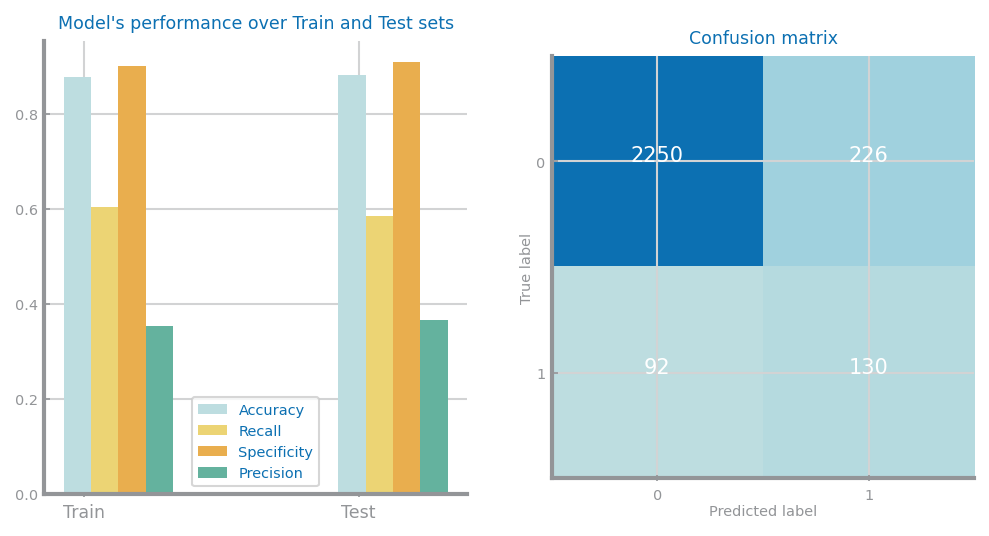

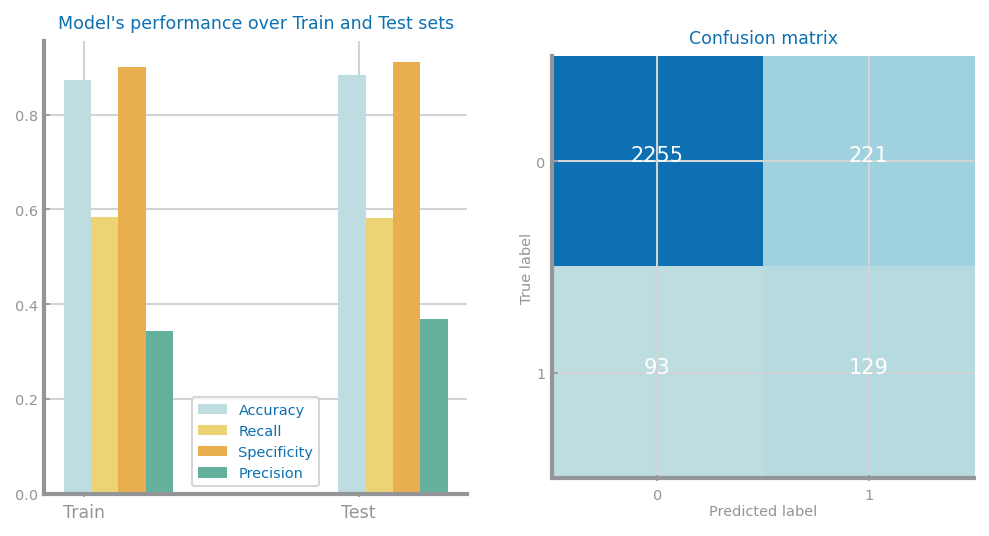

In [53]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
clf = MultinomialNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)


trnX_new, tstX_new, trnY_new, tstY_new = train_test_split(X_new, y_new, train_size=0.7, stratify=y_new, random_state=42)
clf = MultinomialNB()
clf.fit(trnX_new, trnY_new)
prd_trn_new = clf.predict(trnX_new)
prd_tst_new = clf.predict(tstX_new)
ds.plot_evaluation_results(pd.unique(y_new), trnY_new, prd_trn_new, tstY_new, prd_tst_new)

* ### This is then the final feature selection for dataset 2

(8991, 1024)
(8991, 234)


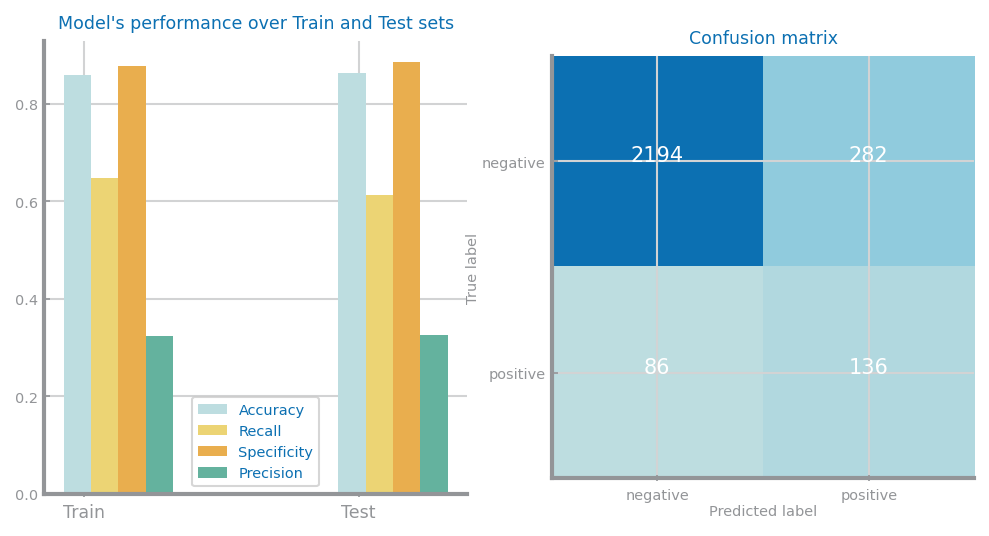

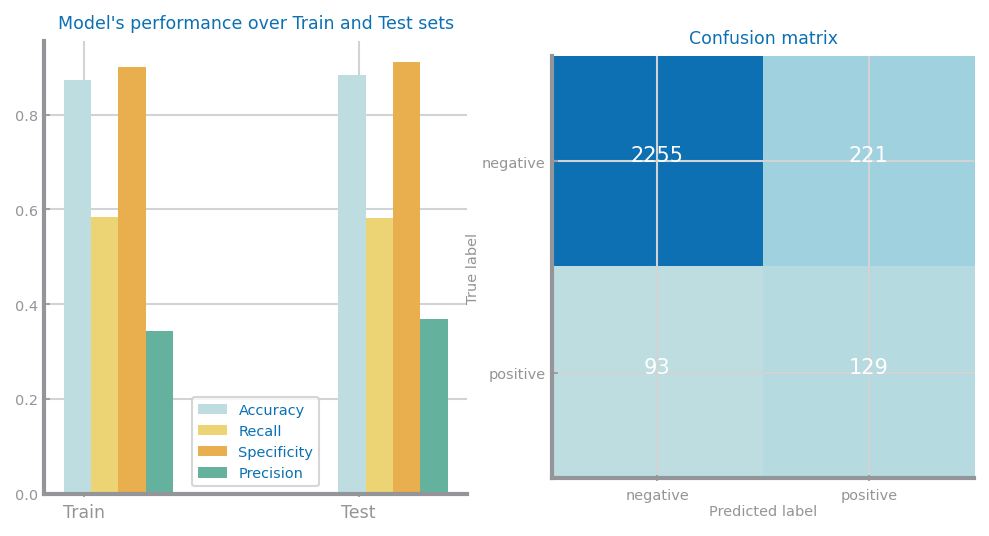

In [63]:
df = data2.copy()
# Cast target variable to binary
#df[df.columns[-1]] = (df[df.columns[-1]] == 'positive').astype(int)

y: np.ndarray = df.pop(df.columns[-1]).values
X: np.ndarray = df.values
print(X.shape)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y_best, random_state=42)
clf = MultinomialNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)


df = data2.copy()
X_best, y_best = best_feature_selection_data2(df)
print(X_best.shape)

trnX, tstX, trnY, tstY = train_test_split(X_best, y_best, train_size=0.7, stratify=y_best, random_state=42)
clf = MultinomialNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y_best), trnY, prd_trn, tstY, prd_tst)